tf-gpu

In [3]:
import numpy as np 
import pandas as pd
import os
from tensorflow.keras import Sequential
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import Flatten, Dense, MaxPooling2D, Conv2D, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import img_to_array, load_img


In [4]:
import tensorflow as tf

gpus = tf.config.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
    except RuntimeError as e:
        print(e)


In [5]:
import tensorflow as tf

print("TensorFlow version:", tf.__version__)
print("Built with CUDA support:", tf.test.is_built_with_cuda())
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

TensorFlow version: 2.13.0
Built with CUDA support: False
Num GPUs Available:  0


In [6]:

# Model creation
model = Sequential()

# Add Batch Normalization at the start
model.add(BatchNormalization(input_shape=(256,256,3)))

model.add(Conv2D(64, (3,3), activation='relu'))
model.add(Dropout(0.5))  # Add Dropout before MaxPooling
model.add(MaxPooling2D((2,2)))

model.add(Conv2D(128, (3,3), activation='relu'))
model.add(Dropout(0.5))  # Add Dropout before MaxPooling
model.add(MaxPooling2D((2,2)))

model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 batch_normalization (Batch  (None, 256, 256, 3)       12        
 Normalization)                                                  
                                                                 
 conv2d (Conv2D)             (None, 254, 254, 64)      1792      
                                                                 
 dropout (Dropout)           (None, 254, 254, 64)      0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 127, 127, 64)      0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 128)     73856     
                                                                 
 dropout_1 (Dropout)         (None, 125, 125, 128)     0

In [5]:

# Compile the model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])


In [8]:

# Dataset path
dataset_path = r'C:\saanvi_code\CropDoctor\Crop_Diseases'

# Data generation
datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)

train_set = datagen.flow_from_directory(
    dataset_path,
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='training')  # set as training data

validation_set = datagen.flow_from_directory(
    dataset_path,  # same directory as training data
    target_size=(256, 256),
    batch_size=32,
    class_mode='categorical',
    subset='validation')  # set as validation data


Found 10664 images belonging to 17 classes.
Found 2660 images belonging to 17 classes.


In [14]:

# Early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=5)

# Model checkpoint callback to save the best model
checkpoint = ModelCheckpoint(
    filepath='best_model.h5',  # Filepath to save the model
    monitor='val_loss',  # Monitor validation loss
    save_best_only=True,  # Save the model only if it has the best validation loss
    mode='min',  # Save when val_loss is minimized
    verbose=1  # Print info when model is saved
)


In [ ]:

# Training the model
history = model.fit(
    train_set,
    epochs=20,
    batch_size=2,
    validation_data=validation_set,
    callbacks=[early_stopping, checkpoint]  # Add both callbacks
)


In [ ]:

# Plot training & validation accuracy values
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')


In [ ]:

# Plot training & validation loss values
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')

plt.tight_layout()
plt.show()


In [9]:

# Load and preprocess image for prediction
classes = train_set.class_indices
icd = {i: j for j, i in classes.items()}


In [30]:
test_loss, test_accuracy = model.evaluate(validation_set)
print("Test Accuracy: {:.2f}%".format(test_accuracy * 100))

84/84 [==============================] - 15s 176ms/step - loss: 0.5293 - accuracy: 0.7789
Test Accuracy: 77.89%


In [27]:

def output(location):
    # Load and preprocess image for prediction
    img = load_img(location, target_size=(256, 256, 3))
    img_array = img_to_array(img)
    img_scaled = img_array / 255
    img_scaled = np.expand_dims(img_scaled, [0])
    
    # Predict the class
    predict_x = model.predict(img_scaled)
    classes_x = np.argmax(predict_x, axis=1)
    predicted_class = icd[classes_x[0]]
    
    # Display the image (remove the batch dimension by selecting the 0th index)
    plt.imshow(img_array.astype('uint8'))  # No need to rescale again for displaying
    plt.axis('off')  # Turn off axis
    plt.title(f'Predicted Class: {predicted_class}')  # Show predicted class as title
    plt.show()
    
    # Print predicted class
    print('Predicted Class:', predicted_class)


1/1 [==============================] - 0s 21ms/step


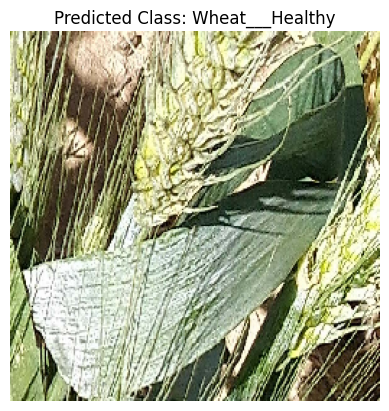

Predicted Class: Wheat___Healthy


In [29]:
output(r"C:\saanvi_code\CropDoctor\Crop_Diseases\Wheat___Healthy\Healthy002.jpg")

In [16]:
!pip uninstall tensorflowjs


^C


In [7]:
!tensorflowjs_converter --input_format keras best_model.h5 C:\saanvi_code\CropDoctor

Traceback (most recent call last):
  File "C:\Users\mails\anaconda3\envs\tfod\lib\runpy.py", line 194, in _run_module_as_main
    return _run_code(code, main_globals, None,
  File "C:\Users\mails\anaconda3\envs\tfod\lib\runpy.py", line 87, in _run_code
    exec(code, run_globals)
  File "C:\Users\mails\anaconda3\envs\tfod\Scripts\tensorflowjs_converter.exe\__main__.py", line 4, in <module>
  File "C:\Users\mails\anaconda3\envs\tfod\lib\site-packages\tensorflowjs\__init__.py", line 21, in <module>
    from tensorflowjs import converters
  File "C:\Users\mails\anaconda3\envs\tfod\lib\site-packages\tensorflowjs\converters\__init__.py", line 21, in <module>
    from tensorflowjs.converters.converter import convert
  File "C:\Users\mails\anaconda3\envs\tfod\lib\site-packages\tensorflowjs\converters\converter.py", line 29, in <module>
    import tensorflow.compat.v1 as tf1
ModuleNotFoundError: No module named 'tensorflow.compat'


In [10]:
import json

# Assuming you have the class mapping dictionary `icd`
# For example:
# icd = {0: 'Healthy', 1: 'Diseased', ...}

# Create a reverse mapping (index to class name)
class_mapping = {v: k for k, v in icd.items()}

# Save the mapping to a JSON file
with open('classes.json', 'w') as json_file:
    json.dump(class_mapping, json_file)

print("classes.json created successfully.")


classes.json created successfully.
